In [1]:
from src import Modeler, Processor, Reader
import pandas as pd
from datetime import datetime
from sklearn import metrics, model_selection, preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
import time

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

In [2]:
# Using the US Census regions from here: https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf
south_atlantic_states = [
    10   # Delaware
    , 11 # DC
    , 12 # Florida
    , 13 # Georgia
    , 24 # Maryland
    , 37 # North Carolina
    , 45 # South Carolina
    , 51 # Virginia
    , 54 # West Virginia
]
state_filter = south_atlantic_states

In [3]:
state_dict = {
    'code' : ['10', '11', '12', '13', '24', '37', '45', '51', '54']
    , 'state_name' : ['Delware', 'DC', 'Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia', 'West Virginia']
}

state_code_map = pd.DataFrame(data=state_dict)

## Loading data

In [4]:
# Instantiate preprocessor
preprocessor = Processor.PreProcessor(state_filter=state_filter)

In [5]:
# Put data into a df to work with
df = preprocessor.get_processed_data()

/Users/elizabethmartens/cs5644/project/projectGitRepo/src/Processor.py:37: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  merged_df = self.init_cdc_data().merge(self.init_vaccinations_data(), how='left', on=['date', 'FIPS'])
/Users/elizabethmartens/cs5644/project/projectGitRepo/src/Processor.py:37: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  merged_df = self.init_cdc_data().merge(self.init_vaccinations_data(), how='left', on=['date', 'FIPS'])


In [6]:
# Export data to csv so that the data does not have to be recreated each run
df.to_csv('COVID_Analysis_Data.csv',index=False)
# Show data
df.head()

,FIPS_10001,FIPS_10003,FIPS_10005,FIPS_11001,FIPS_12001,FIPS_12003,FIPS_12005,FIPS_12007,FIPS_12009,FIPS_12011,...,is_metro,Series_Complete_Pop_Pct_UR_Equity,cases,deaths,8_days_prior_cases,9_days_prior_cases,10_days_prior_cases,8_days_prior_deaths,9_days_prior_deaths,10_days_prior_deaths
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,25.142857,0.142857,3.428571,3.857143,3.428571,0.285714,0.285714,0.285714
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,26.714286,0.285714,4.714286,3.428571,3.857143,0.285714,0.285714,0.285714
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,27.857143,0.285714,6.142857,4.714286,3.428571,0.0,0.285714,0.285714
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,22.857143,0.428571,8.714286,6.142857,4.714286,0.0,0.0,0.285714
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,26.0,0.571429,14.428571,8.714286,6.142857,0.142857,0.0,0.0


In [7]:
# Load data
#df = pd.read_csv("COVID_Analysis_Data.csv", dtypes={'date':''})

In [8]:
df.shape

(289884, 704)

## Split into train and test

In [9]:
modeler = Modeler.Modeler()

In [10]:
# Split data into training and test dataset:
train_end_date = '2021-06-14'
X_train, y_train_cases, y_train_deaths, X_test, y_test_cases, y_test_deaths = modeler.split_train_test(df, train_end_date)

### Unpivoted data

In [11]:
unpivoted_df = preprocessor.get_processed_data_without_fips_as_columns(set_current_data=False)

/Users/elizabethmartens/cs5644/project/projectGitRepo/src/Processor.py:37: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  merged_df = self.init_cdc_data().merge(self.init_vaccinations_data(), how='left', on=['date', 'FIPS'])
/Users/elizabethmartens/cs5644/project/projectGitRepo/src/Processor.py:37: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  merged_df = self.init_cdc_data().merge(self.init_vaccinations_data(), how='left', on=['date', 'FIPS'])


In [12]:
unpivoted_cases = unpivoted_df[['date', 'FIPS', 'cases']].copy()
unpivoted_cases['STATE'] = unpivoted_cases['FIPS'].apply(lambda x: x[:2])
unpivoted_cases = unpivoted_cases.merge(state_code_map, left_on='STATE', right_on='code', how='left')

In [13]:
unpivoted_cases_test = unpivoted_cases[unpivoted_cases['date'] > train_end_date]

In [14]:
unpivoted_deaths = unpivoted_df[['date', 'FIPS', 'deaths']].copy()
unpivoted_deaths['STATE'] = unpivoted_deaths['FIPS'].apply(lambda x: x[:2])
unpivoted_deaths = unpivoted_deaths.merge(state_code_map, left_on='STATE', right_on='code', how='left')

In [15]:
unpivoted_deaths_test = unpivoted_deaths[unpivoted_deaths['date'] > train_end_date]

## Plotting functions

In [16]:
def plot_predictions(y_test, y_pred, model_name=None, target_name=None):
    plt.figure(figsize=(9,6))
    plt.scatter(y_test, y_pred, color='none', edgecolor='b')
    xymin = min(np.min(y_test), np.min(y_pred))
    xymax = max(np.max(y_test), np.max(y_pred))
    plt.plot([xymin, xymax],[xymin, xymax], color="r", linestyle="--")
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    if model_name:
        plt.title(f'{model_name}: {target_name} Actuals vs Predicted', fontsize=16)
    else:
        plt.title('Actuals vs Predicted', fontsize=16)
    plt.show()
    
def plot_predictions_w_state(y_test, y_pred, unpivoted_test_df, model_name=None, target_name=None):
    plt.figure(figsize=(9,6))
    sns.scatterplot(x=y_test, y=y_pred, hue=unpivoted_test_df['state_name'])
    xymin = min(np.min(y_test), np.min(y_pred))
    xymax = max(np.max(y_test), np.max(y_pred))
    plt.plot([xymin, xymax],[xymin, xymax], color="r", linestyle="--")
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    if model_name:
        plt.title(f'{model_name}: {target_name} Actuals vs Predicted by state', fontsize=16)
    else:
        plt.title('Actuals vs Predicted by state', fontsize=16)
    plt.show()
    
def plot_residuals(X_test, residuals, model_name=None, target_name=None):
    plt.figure(figsize=(18, 6))
    sns.scatterplot(x=df['date'], y=residuals, color='none', edgecolor='r')
    if model_name:
        plt.title(f'{model_name}: {target_name} Residuals', fontsize=16)
    else:
        plt.title('Residuals', fontsize=16)
    plt.show()
    
def plot_residuals_w_state(X_test, residuals, unpivoted_test_df, model_name=None, target_name=None):
    plt.figure(figsize=(18, 6))
    sns.scatterplot(x=df['date'], y=residuals, hue=unpivoted_test_df['state_name'])
    if model_name:
        plt.title(f'{model_name}: {target_name} Residuals by state', fontsize=16)
    else:
        plt.title('Residuals by state', fontsize=16)
    plt.show()

## Modeling functions

In [17]:
def run_full_pipeline(model, X_train, y_train, X_test, y_test, unpivoted_test_df, model_name=None, target_name=None):
    if model_name:
        print(f'{model_name}: {target_name}')
    # Cross validate and report scores:
    scores = modeler.cv_model(model, X_train, y_train)
    print('Cross-Validation Scores:')
    for k, v in scores.items():
        print(f'\t{k}: {round(v[0],2)} +/- {round(v[1],2)}')
    # Test data
    start = time.time()
    y_pred, rmse, r2, fit_time, fit_predict_time = modeler.test_model(model, X_train, y_train, X_test, y_test)
    residuals = (y_test - y_pred)
    print(f'Time to fit model: {fit_time}')
    print(f'Time to fit model and predict: {fit_time}')
    # Plots
    plot_predictions(y_test, y_pred, model_name, target_name)
    plot_residuals(X_test, residuals, model_name, target_name)
    plot_predictions_w_state(y_test, y_pred, unpivoted_test_df, model_name, target_name)
    plot_residuals_w_state(X_test, residuals, unpivoted_test_df, model_name, target_name)
    return y_pred, residuals, rmse, r2, fit_time

## Linear Regression

In [18]:
lm_model = LinearRegression()

### All Data - Cases

Linear Regression: Cases
Cross-Validation Scores:
	RMSE: 21.38 +/- 1.15
	r2: 0.94 +/- 0.01
Model testing scores:
RMSE: 33.59
R^2 Score: 0.91
Time to fit model: 19.715254068374634
Time to fit model and predict: 19.715254068374634


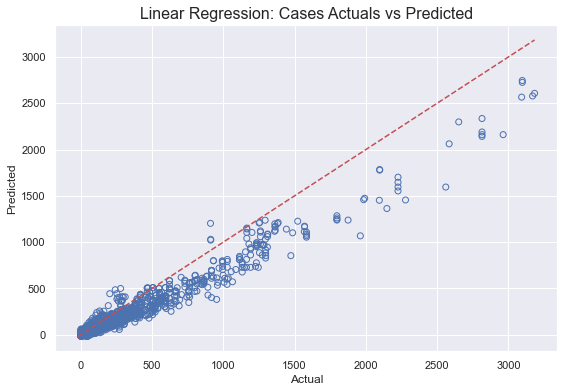

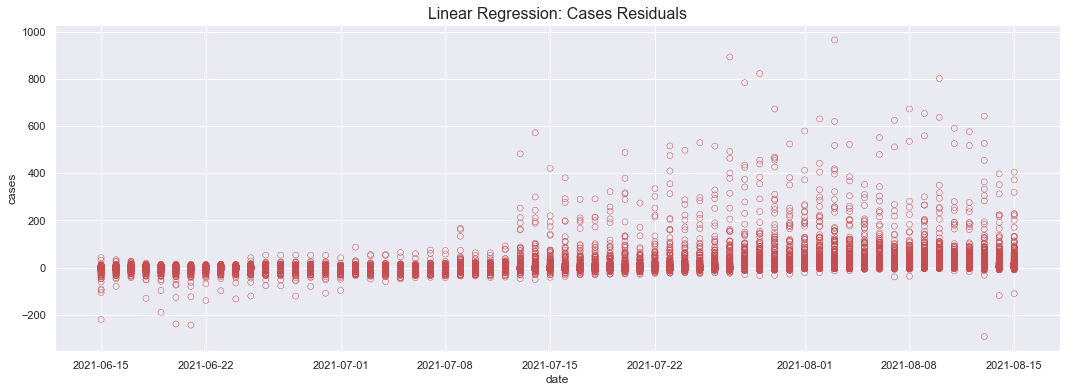

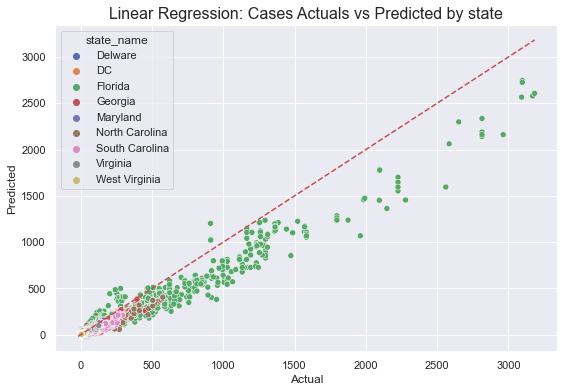

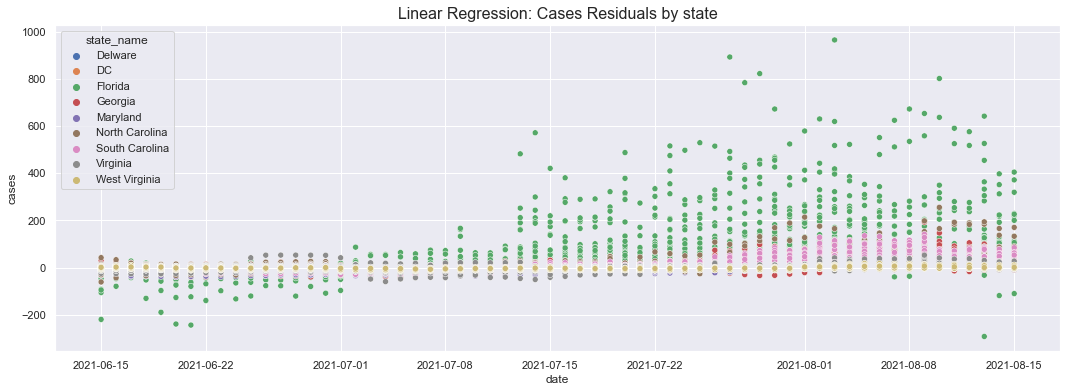

In [19]:
cases_pred_lm, cases_residuals_lm, cases_rmse_lm, cases_r2_lm, cases_fit_time_lm = run_full_pipeline(
    lm_model
    , X_train
    , y_train_cases
    , X_test
    , y_test_cases
    , unpivoted_cases_test
    , 'Linear Regression'
    , 'Cases'
)


### All Data - deaths

Linear Model: Deaths
Cross-Validation Scores:
	RMSE: 0.55 +/- 0.02
	r2: 0.79 +/- 0.01
Model testing scores:
RMSE: 0.33
R^2 Score: 0.73
Time to fit model: 19.781904935836792
Time to fit model and predict: 19.781904935836792


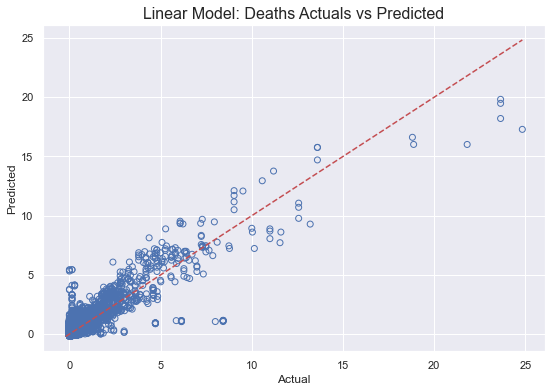

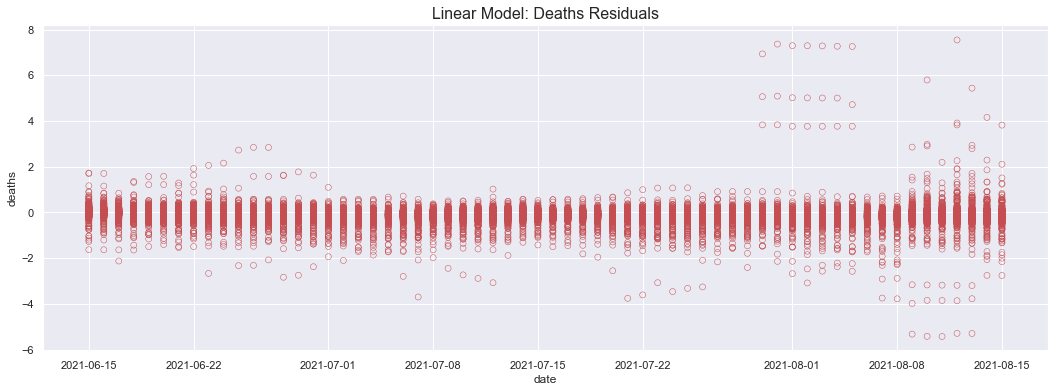

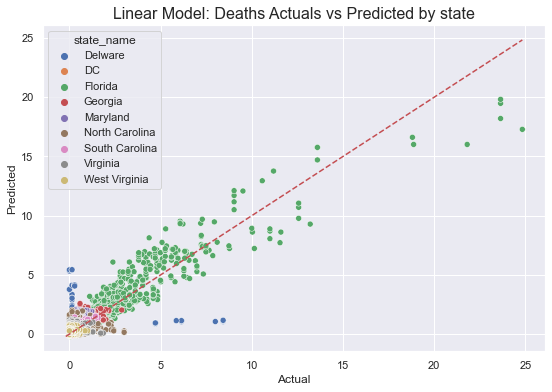

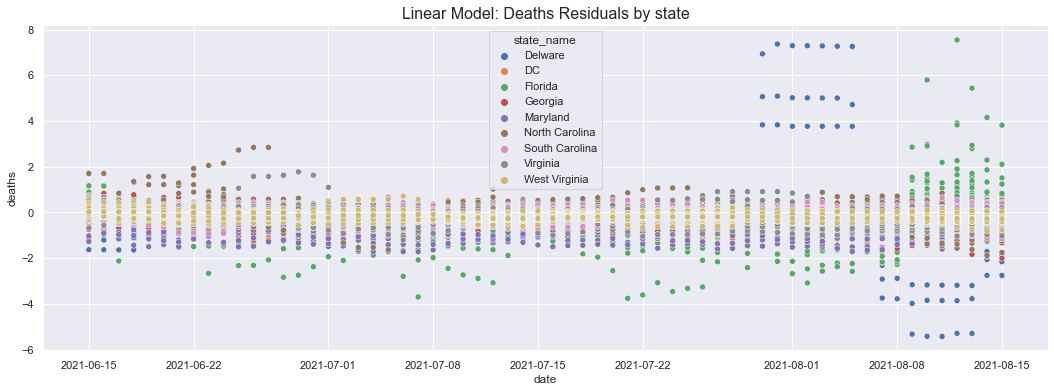

In [20]:
deaths_pred_lm, deaths_residuals_lm, deaths_rmse_lm, deaths_r2_lm, deaths_fit_time_lm = run_full_pipeline(
    lm_model
    , X_train
    , y_train_deaths
    , X_test
    , y_test_deaths
    , unpivoted_deaths_test
    , 'Linear Model'
    , 'Deaths'
)


# Decision Tree

In [21]:
dt_model = DecisionTreeRegressor(random_state=1)

### All Data - Cases

Decision Tree: Cases
Cross-Validation Scores:
	RMSE: 17.03 +/- 1.34
	r2: 0.96 +/- 0.01
Model testing scores:
RMSE: 51.31
R^2 Score: 0.79
Time to fit model: 47.06050109863281
Time to fit model and predict: 47.06050109863281


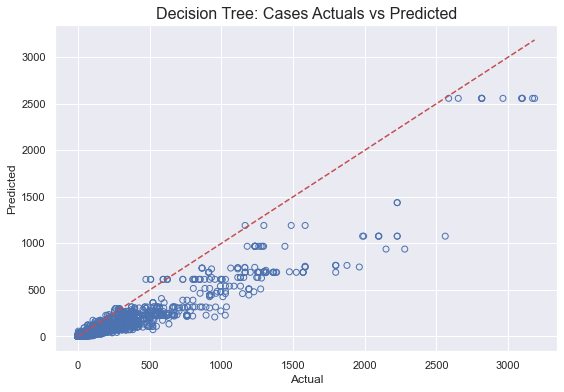

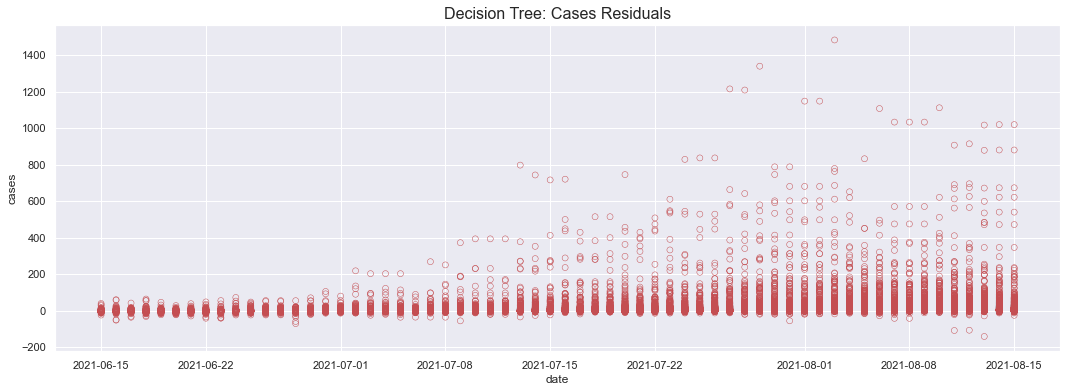

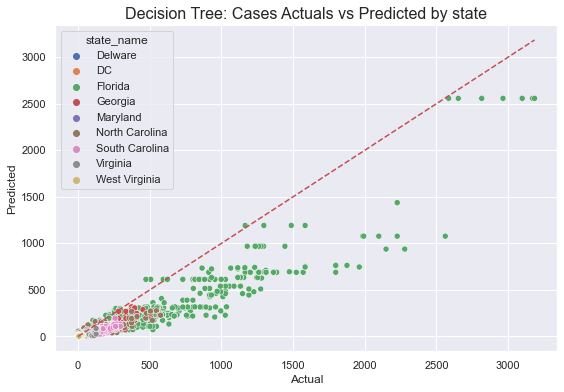

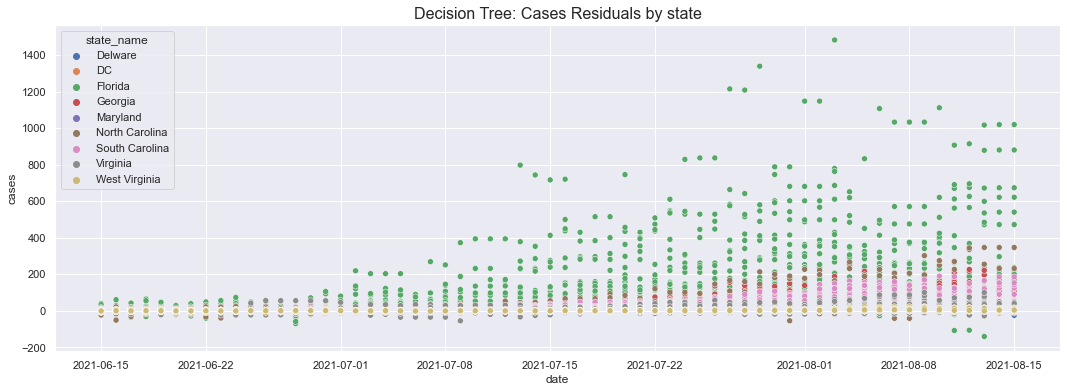

In [22]:
cases_pred_dt, cases_residuals_dt, cases_rmse_dt, cases_r2_dt, cases_fit_time_dt = run_full_pipeline(
    dt_model
    , X_train
    , y_train_cases
    , X_test
    , y_test_cases
    , unpivoted_cases_test
    , 'Decision Tree'
    , 'Cases'
)


### All Data - deaths

Decision Tree: Deaths
Cross-Validation Scores:
	RMSE: 0.49 +/- 0.01
	r2: 0.83 +/- 0.01
Model testing scores:
RMSE: 0.78
R^2 Score: -0.52
Time to fit model: 57.603835105895996
Time to fit model and predict: 57.603835105895996


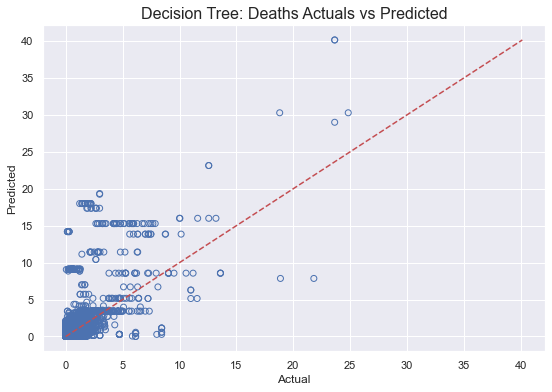

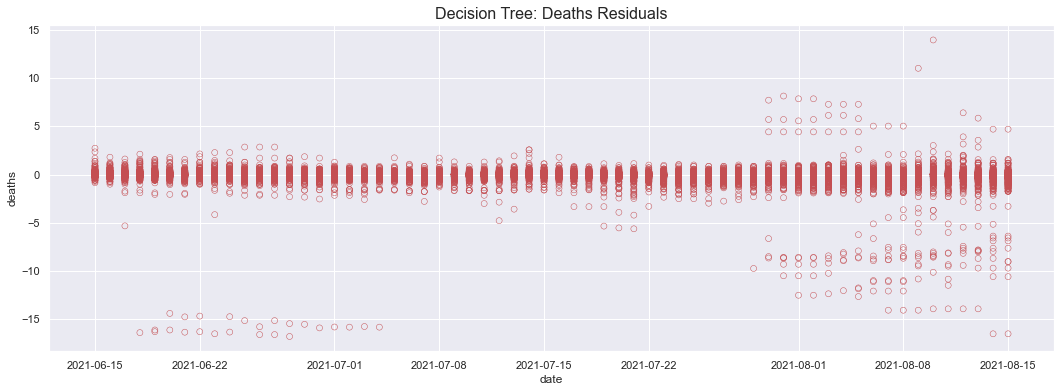

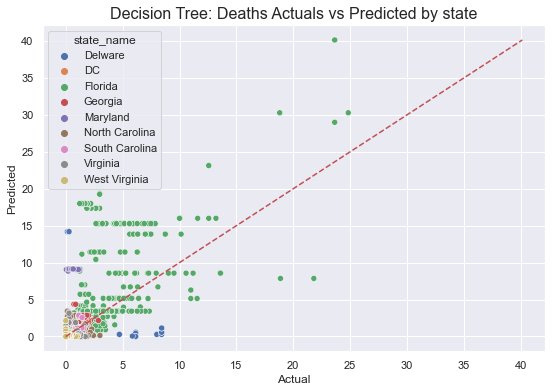

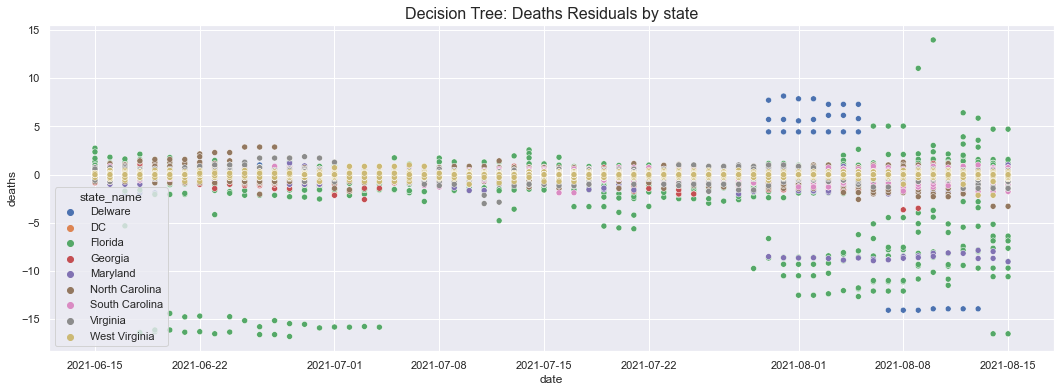

In [23]:
deaths_pred_dt, deaths_residuals_dt, deaths_rmse_dt, deaths_r2_dt, deaths_fit_time_dt = run_full_pipeline(
    dt_model
    , X_train
    , y_train_deaths
    , X_test
    , y_test_deaths
    , unpivoted_deaths_test
    , 'Decision Tree'
    , 'Deaths'
)


# Gradient Boosting

In [24]:
gb_model = GradientBoostingRegressor(random_state=1, max_depth=2, n_estimators=50)

### All Data - Cases

Gradient Boosting: Cases
Cross-Validation Scores:
	RMSE: 20.64 +/- 0.97
	r2: 0.94 +/- 0.0
Model testing scores:
RMSE: 42.07
R^2 Score: 0.86
Time to fit model: 102.42905187606812
Time to fit model and predict: 102.42905187606812


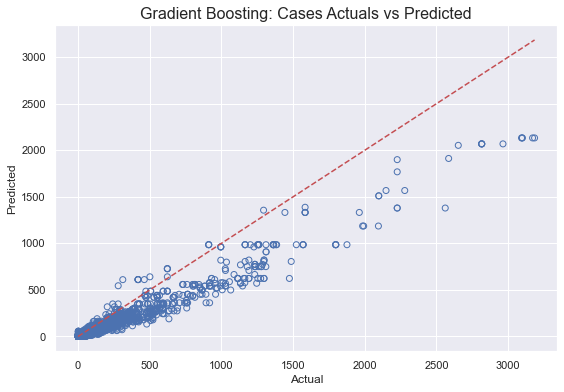

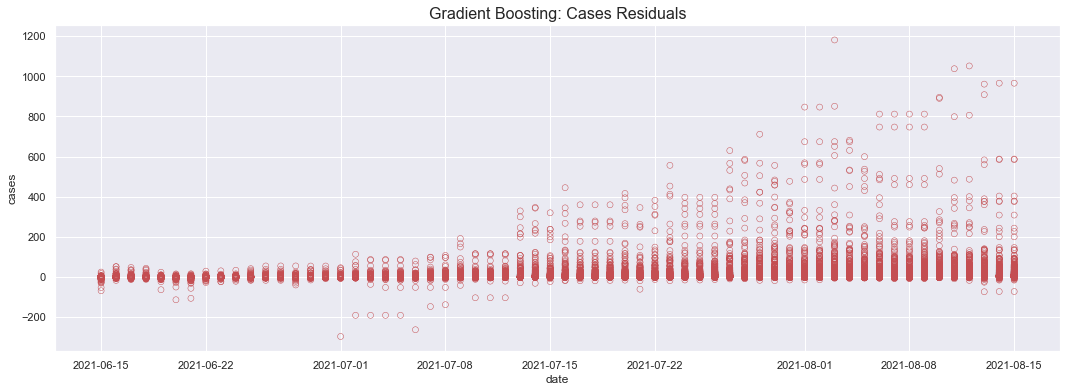

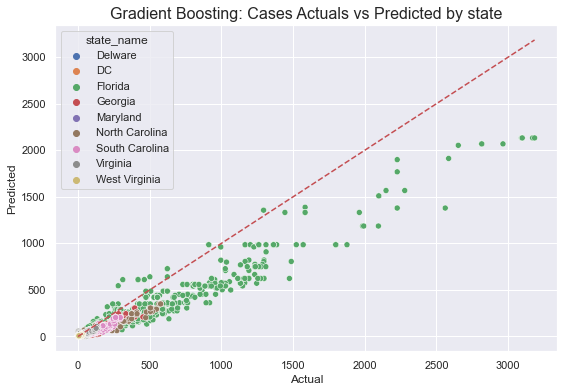

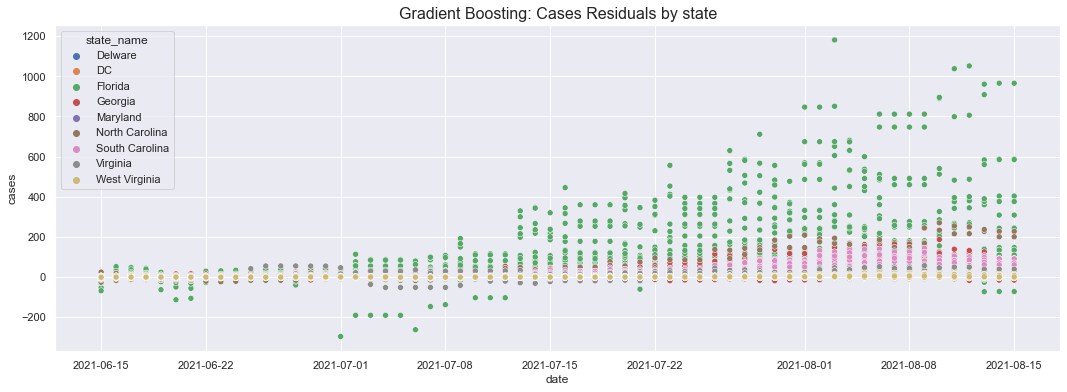

In [25]:
cases_pred_gb, cases_residuals_gb, cases_rmse_gb, cases_r2_gb, cases_fit_time_gb = run_full_pipeline(
    gb_model
    , X_train
    , y_train_cases
    , X_test
    , y_test_cases
    , unpivoted_cases_test
    , 'Gradient Boosting'
    , 'Cases'
)


### All Data - deaths

Gradient Boosting: Deaths
Cross-Validation Scores:
	RMSE: 0.54 +/- 0.02
	r2: 0.79 +/- 0.01
Model testing scores:
RMSE: 0.29
R^2 Score: 0.79
Time to fit model: 100.26641488075256
Time to fit model and predict: 100.26641488075256


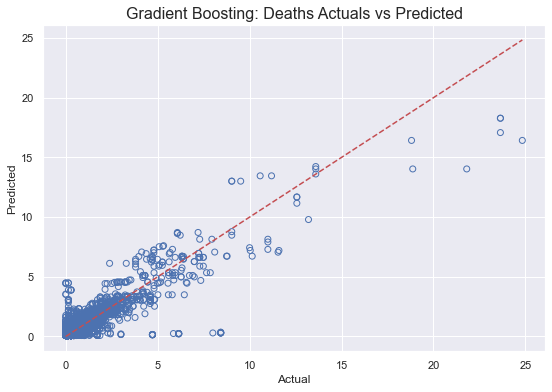

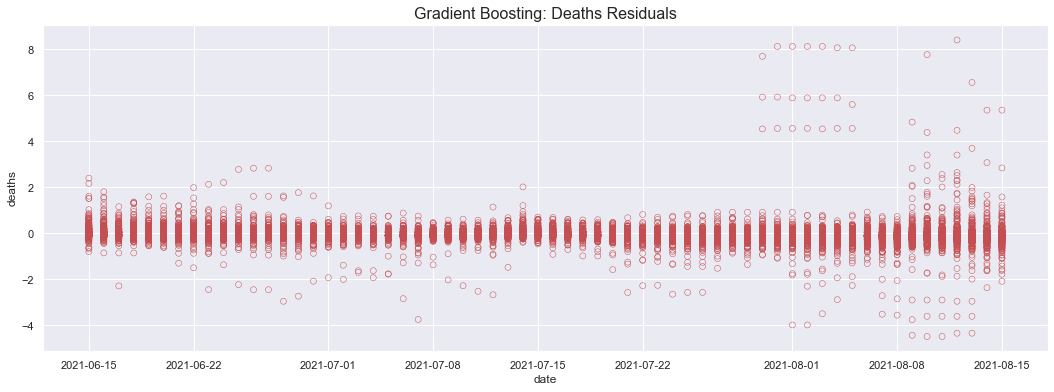

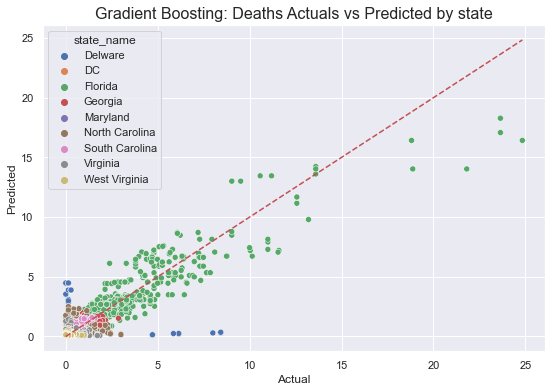

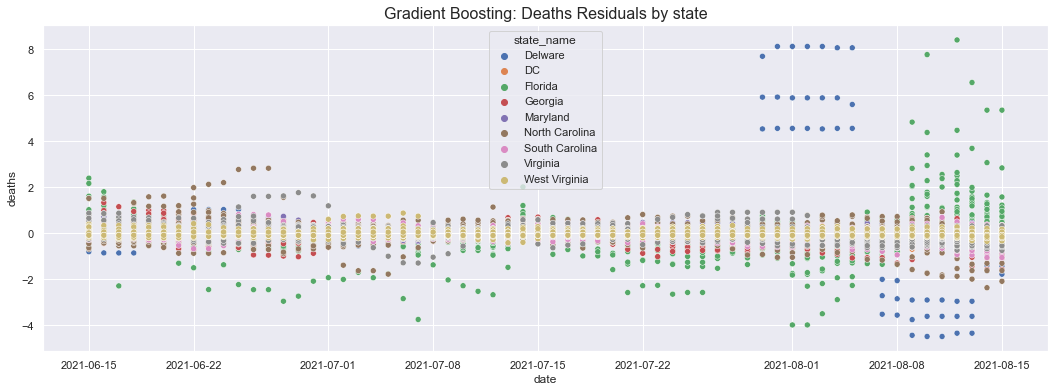

In [26]:
deaths_pred_gb, deaths_residuals_gb, deaths_rmse_gb, deaths_r2_gb, deaths_fit_time_gb = run_full_pipeline(
    gb_model
    , X_train
    , y_train_deaths
    , X_test
    , y_test_deaths
    , unpivoted_deaths_test
    , 'Gradient Boosting'
    , 'Deaths')


## Visualizing Results

In [27]:
print('Linear Regression RMSE:')
print(f'\tCases: {cases_rmse_lm:.2f}')
print(f'\tDeaths: {deaths_rmse_lm:.2f}')
print('Decision Tree RMSE:')
print(f'\tCases: {cases_rmse_dt:.2f}')
print(f'\tDeaths: {deaths_rmse_dt:.2f}')
print('Gradient Boosting RMSE:')
print(f'\tCases: {cases_rmse_gb:.2f}')
print(f'\tDeaths: {deaths_rmse_gb:.2f}')
# print('KNN Regression RMSE:', rmse_knn)

Linear Regression RMSE:
	Cases: 33.59
	Deaths: 0.33
Decision Tree RMSE:
	Cases: 51.31
	Deaths: 0.78
Gradient Boosting RMSE:
	Cases: 42.07
	Deaths: 0.29


In [28]:
train_mask = (df['date'] <= train_end_date)
df_train = df[train_mask]
df_test = df[~train_mask]

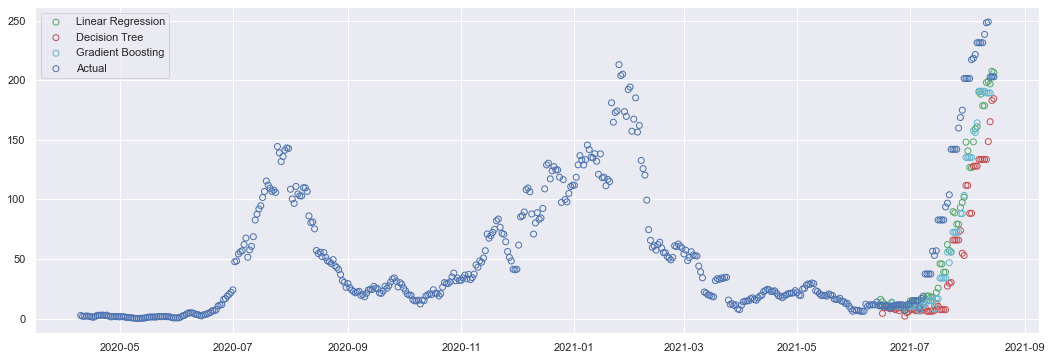

In [29]:
# Checking out how the prediction looked vs the model
county_mask = df_test['FIPS_12005'] == 1
county_mask_train = df_train['FIPS_12005'] == 1
plt.figure(figsize=(18, 6))
plt.scatter(x=df_test[county_mask]['date'], y=cases_pred_lm[county_mask], color='none', edgecolor='g')
plt.scatter(x=df_test[county_mask]['date'], y=cases_pred_dt[county_mask], color='none', edgecolor='r')
plt.scatter(x=df_test[county_mask]['date'], y=cases_pred_gb[county_mask], color='none', edgecolor='c')
plt.scatter(x=df_train[county_mask_train]['date'], y=y_train_cases[county_mask_train], color='none', edgecolor='b')
plt.scatter(x=df_test[county_mask]['date'], y=y_test_cases[county_mask], color='none', edgecolor='b');
plt.legend(['Linear Regression', 'Decision Tree', 'Gradient Boosting', 'Actual'], loc='upper left');

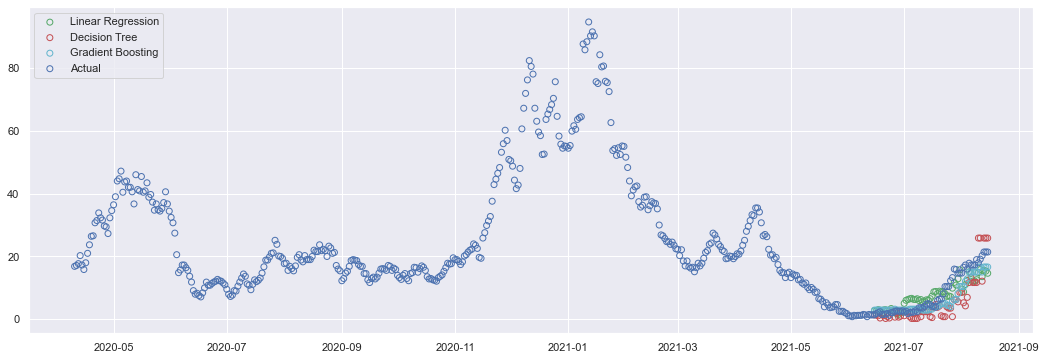

In [30]:
# Checking out how the prediction looked vs the model (Alexandria, VA FIPS 51510)
county_mask = X_test['FIPS_51510'] == 1
county_mask_train = X_train['FIPS_51510'] == 1
plt.figure(figsize=(18, 6))
plt.scatter(x=df_test[county_mask]['date'], y=cases_pred_lm[county_mask], color='none', edgecolor='g')
plt.scatter(x=df_test[county_mask]['date'], y=cases_pred_dt[county_mask], color='none', edgecolor='r')
plt.scatter(x=df_test[county_mask]['date'], y=cases_pred_gb[county_mask], color='none', edgecolor='c')
plt.scatter(x=df_train[county_mask_train]['date'], y=y_train_cases[county_mask_train], color='none', edgecolor='b')
plt.scatter(x=df_test[county_mask]['date'], y=y_test_cases[county_mask], color='none', edgecolor='b');
plt.legend(['Linear Regression', 'Decision Tree', 'Gradient Boosting', 'Actual'], loc='upper left');

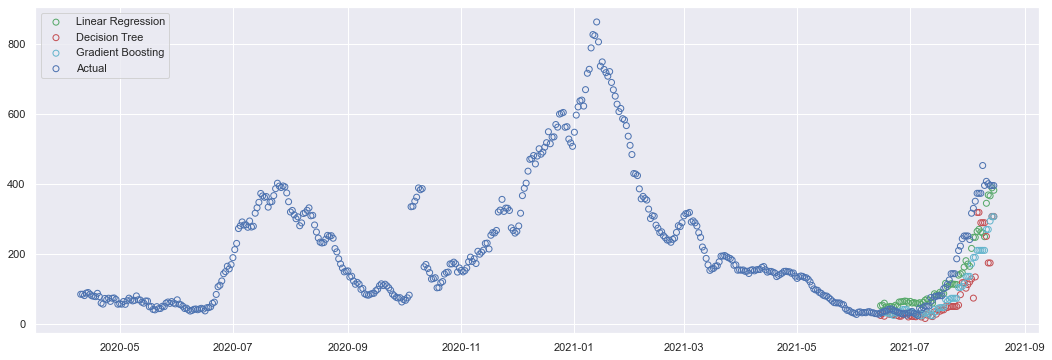

In [31]:
# Checking out how the prediction looked vs the model (Atlanta, GA Fulton county 13121)
county_mask = X_test['FIPS_13121'] == 1
county_mask_train = X_train['FIPS_13121'] == 1
plt.figure(figsize=(18, 6))
plt.scatter(x=df_test[county_mask]['date'], y=cases_pred_lm[county_mask], color='none', edgecolor='g')
plt.scatter(x=df_test[county_mask]['date'], y=cases_pred_dt[county_mask], color='none', edgecolor='r')
plt.scatter(x=df_test[county_mask]['date'], y=cases_pred_gb[county_mask], color='none', edgecolor='c')
plt.scatter(x=df_train[county_mask_train]['date'], y=y_train_cases[county_mask_train], color='none', edgecolor='b')
plt.scatter(x=df_test[county_mask]['date'], y=y_test_cases[county_mask], color='none', edgecolor='b');
plt.legend(['Linear Regression', 'Decision Tree', 'Gradient Boosting', 'Actual'], loc='upper left');

In [32]:
# Test out combining all of the data for a single state and seeing how far off cases/deaths predictions were?


### Removing FL

In [33]:
df_no_fl = df[df['STATE_12'] != 1].drop(['STATE_12'], axis=1)
df_no_fl = df_no_fl.drop([c for c in df_no_fl.columns if c[:7] == 'FIPS_12'], axis=1)

In [34]:
# Split data into training and test dataset:
train_end_date = '2021-06-14'
X_train, y_train_cases, y_train_deaths, X_test, y_test_cases, y_test_deaths = modeler.split_train_test(df_no_fl, train_end_date)

#### Cases

In [35]:
# cases_pred, cases_residuals, cases_rmse, cases_r2 = run_full_pipeline(lm_model, X_train, y_train_cases, X_test, y_test_cases)

#### Deaths

In [36]:
# deaths_pred, deaths_residuals, deaths_rmse, deaths_r2 = run_full_pipeline(lm_model, X_train, y_train_deaths, X_test, y_test_deaths)

In [37]:
# Test out combining all of the data for a single state and seeing how far off cases/deaths predictions were?
